In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [28]:
band1 = np.load('Tori_Seed_Unpolish_Infected_Tobamo_S2_Vnir__T11_2022-08-28_11-20-20_band_200.npy')
band2 = np.load('Tori_Seed_Unpolish_Infected_Tobamo_S2_Vnir__T12_2022-08-28_11-23-17_band_200.npy')

band_width = band1.shape[1]
band_height = band1.shape[0]

In [4]:
def display_band(band):
    plt.imshow(band, cmap='gray')
    plt.title(f'Band')
    plt.colorbar()
    plt.show()

def display_row(band, row):
    row_band = band.copy()
    row_band[row:row+3,:] = 4000
    display_band(row_band)
    
def display_column(band, column):
    column_band = band.copy()
    column_band[81:,column:column+3] = 4000
    display_band(column_band)

Find the end of the sticker using a threshold that the maximum value in sticker row should not be below of.

In [5]:
line_thickness = 3
line_value = 4000

In [22]:
def find_after_sticker_index(band):
    sticker_value_threshold = 2000
    is_end_of_sticker_found = False
    change_counter_sticker_threshold = 5
    change_counter = 0
    mask = band[0,:] > sticker_value_threshold
    is_start_of_sticker_found = len(mask[mask == True]) > 100
    after_sticker_index = 1

    while not is_end_of_sticker_found or after_sticker_index > band1.shape[0]:
        mask = band[after_sticker_index,:] > sticker_value_threshold
        is_row_sticker = len(mask[mask == True]) > 100
        if not is_start_of_sticker_found and is_row_sticker:
            is_start_of_sticker_found = True
        elif is_start_of_sticker_found and not is_row_sticker:
            if change_counter < change_counter_sticker_threshold:
                change_counter += 1
            else:
                is_end_of_sticker_found = True
        after_sticker_index += 1
        
    return after_sticker_index - change_counter_sticker_threshold + 1

after_sticker_index1 = find_after_sticker_index(band1)
after_sticker_index2 = find_after_sticker_index(band2)
print(after_sticker_index1)
print(after_sticker_index2)

83
102


Find rows and columns using the momentum changes from an empty line to a seed line and vice versa.
A momentum change is set when the average pixel value in the row or the column passes a threshold for a couple of persistant bands.
After all the momentum changes are found the empty columns wrappers are averaged to get the separators between the rows and the columns.
The middle empty columns wrappers change like their paired seed wrapper.

In [25]:
# Helper function in debugging

def print_row(band, row_index):
    print(row_index, ': max=', np.max(band[row_index,:,0]))
    print(row_index, ': min=', np.min(band[row_index,:,0]))
    print(row_index, ': average=', np.average(band[row_index,:]))

def print_column(band, after_sticker_index, column_index):
    print(column_index, ': max=', np.max(band[after_sticker_index:,column_index,0]))
    print(column_index, ': min=', np.min(band[after_sticker_index:,column_index,0]))
    print(column_index, ': average=', np.average(band[after_sticker_index:,column_index]))

In [35]:
row_special_threshold = 300  # pixel value more than the average value in that row or column
row_max_number_of_special_in_empty = 60  # number of special pixels in an empty row or column

column_special_threshold = 300  # pixel value more than the average value in that row or column
column_max_number_of_special_in_empty = 200  # number of special pixels in an empty row or column

# Momentum is changed based on several lines in a row that keep the momentum to decrease the noise effect. The number of lines can change between rows and columns.
change_counter_row_threshold = 5
change_counter_column_threshold = 5

In [38]:
def find_row_momentum_changes(band, after_sticker_index, row_special_threshold, row_max_number_of_special_in_empty, change_counter_row_threshold):
    is_changed_to_empty_row = True  # This tells if I changed from an empty row to a seed row
    change_counter = 0
    switch_momentum_row_indexes = [after_sticker_index]

    for i in range(after_sticker_index, band_height - 1):
        slice = band[i,:]
        average = np.average(band[i,:])
        mask = slice[slice > average + row_special_threshold]
        above_average_number = len(mask == True)
        if is_changed_to_empty_row and above_average_number > row_max_number_of_special_in_empty:  # empty to seed
            if change_counter < change_counter_row_threshold:
                change_counter += 1
            else:
                is_changed_to_empty_row = False
                change_counter = 0
                switch_momentum_row_indexes.append(i-change_counter_row_threshold)
        if not is_changed_to_empty_row and above_average_number < row_max_number_of_special_in_empty:  # seed to empty
            if change_counter < change_counter_row_threshold:
                change_counter += 1
            else:
                is_changed_to_empty_row = True
                change_counter = 0
                switch_momentum_row_indexes.append(i-change_counter_row_threshold)

    switch_momentum_row_indexes.append(band.shape[0] - 1)

    return switch_momentum_row_indexes

momentum_row_changes_indexes1 = find_row_momentum_changes(band1, after_sticker_index1, row_special_threshold, row_max_number_of_special_in_empty, change_counter_row_threshold)
momentum_row_changes_indexes2 = find_row_momentum_changes(band2, after_sticker_index2, row_special_threshold, row_max_number_of_special_in_empty, change_counter_row_threshold)
number_of_row_momentum_changes1 = len(momentum_row_changes_indexes1)
number_of_row_momentum_changes2 = len(momentum_row_changes_indexes2)
print(number_of_row_momentum_changes1)
print(number_of_row_momentum_changes2)

48
48


In [41]:
def find_average_rows_indexes(momentum_row_changes_indexes):
    average_rows_indexes = []
    for i in range(0, len(momentum_row_changes_indexes), 2):
        row = (momentum_row_changes_indexes[i] + momentum_row_changes_indexes[i+1])//2
        average_rows_indexes.append(row)

    return average_rows_indexes

average_rows_indexes1 = find_average_rows_indexes(momentum_row_changes_indexes1)
average_rows_indexes2 = find_average_rows_indexes(momentum_row_changes_indexes2)

In [45]:
def find_momentum_column_changes(band, after_sticker_index, column_special_threshold, column_max_number_of_special_in_empty, change_counter_column_threshold):
    is_changed_to_empty_column = True  # This tells if I changed from an empty row to a seed row
    change_counter = 0
    switch_momentum_column_indexes = [0]

    for i in range(1, band_width-1):
        slice = band[after_sticker_index:, i]
        average = np.average(band1[after_sticker_index:,i])
        mask = slice[slice > average + column_special_threshold]
        above_average_number = len(mask == True)
        if is_changed_to_empty_column and above_average_number > column_max_number_of_special_in_empty:  # empty to seed
            if change_counter < change_counter_column_threshold:
                change_counter += 1
            else:
                is_changed_to_empty_column = False
                change_counter = 0
                switch_momentum_column_indexes.append(i-change_counter_column_threshold)
        if not is_changed_to_empty_column and above_average_number < column_max_number_of_special_in_empty:  # seed to empty
            if change_counter < change_counter_column_threshold:
                change_counter += 1
            else:
                is_changed_to_empty_column = True
                change_counter = 0
                switch_momentum_column_indexes.append(i-change_counter_column_threshold)

    switch_momentum_column_indexes.append(band_width - 1)

    return switch_momentum_column_indexes

momentum_column_changes_indexes1 = find_momentum_column_changes(band1, after_sticker_index1, column_special_threshold, column_max_number_of_special_in_empty, change_counter_column_threshold)
momentum_column_changes_indexes2 = find_momentum_column_changes(band2, after_sticker_index2, column_special_threshold, column_max_number_of_special_in_empty, change_counter_column_threshold)
number_of_column_momentum_changes1 = len(momentum_column_changes_indexes1)
number_of_column_momentum_changes2 = len(momentum_column_changes_indexes2)
print(number_of_column_momentum_changes1)
print(number_of_column_momentum_changes2)

30
30


In [51]:
def find_average_columns_indexes(momentum_column_changes_indexes):
    average_column_indexes = []

    # Find average columns until the middle, change the middle like its paired seed warpper column, and average after the middle.

    i = 0
    for i in range(0, len(momentum_column_changes_indexes)//2 - 1, 2):
        column = (momentum_column_changes_indexes[i] + momentum_column_changes_indexes[i+1])//2
        average_column_indexes.append(column)

    column = momentum_column_changes_indexes[i+2] + (momentum_column_changes_indexes[i] - momentum_column_changes_indexes[i-1])//2
    average_column_indexes.append(column)
    column = momentum_column_changes_indexes[i+3] - (momentum_column_changes_indexes[i+5] - momentum_column_changes_indexes[i+4])//2
    average_column_indexes.append(column)

    for i in range(i + 4, len(momentum_column_changes_indexes), 2):
        column = (momentum_column_changes_indexes[i] + momentum_column_changes_indexes[i+1])//2
        average_column_indexes.append(column)

    return average_column_indexes

average_column_indexes1 = find_average_columns_indexes(momentum_column_changes_indexes1)
average_column_indexes2 = find_average_columns_indexes(momentum_column_changes_indexes2)

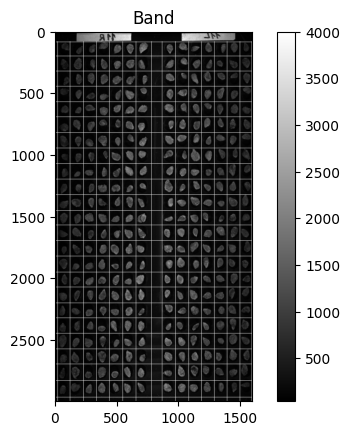

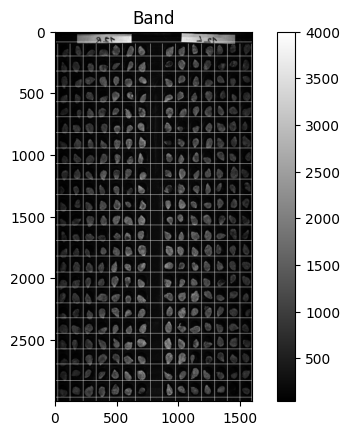

In [52]:
band1_with_average_rows_and_columns = band1.copy()
for row in average_rows_indexes1:
    band1_with_average_rows_and_columns[row:row+line_thickness,:,0] = line_value
for column in average_column_indexes1:
    band1_with_average_rows_and_columns[after_sticker_index1:,column:column+line_thickness,0] = line_value

band2_with_average_rows_and_columns = band2.copy()
for row in average_rows_indexes1:
    band2_with_average_rows_and_columns[row:row+line_thickness,:,0] = line_value
for column in average_column_indexes2:
    band2_with_average_rows_and_columns[after_sticker_index2:,column:column+line_thickness,0] = line_value

display_band(band1_with_average_rows_and_columns)
display_band(band2_with_average_rows_and_columns)

Extract separated seeds indexes.

In [54]:
def extract_separated_images_points(average_rows_indexes, average_column_indexes):
    separated_images_points = []

    for row in range(len(average_rows_indexes) - 1):
        for column in range(1, len(average_column_indexes) - 1):
            separated_images_points.append(((average_rows_indexes[row], average_column_indexes[column]), (average_rows_indexes[row + 1], average_column_indexes[column + 1])))

    return np.array(separated_images_points)

separated_images_points1 = extract_separated_images_points(average_rows_indexes1, average_column_indexes1)
np.save('Tori_Seed_Unpolish_Infected_Tobamo_S2_Vnir__T11_2022-08-28_11-20-20' + f'_sparation.npy', separated_images_points1)
separated_images_points2 = extract_separated_images_points(average_rows_indexes2, average_column_indexes2)
np.save('Tori_Seed_Unpolish_Infected_Tobamo_S2_Vnir__T12_2022-08-28_11-23-17' + f'_sparation.npy', separated_images_points2)

print(len(separated_images_points1))
print(len(separated_images_points2))

322
322


In [59]:
seed_number = 200

seed1_name = 'Tori_Seed_Unpolish_Infected_Tobamo_S2_Vnir__T11_2022-08-28_11-20-20' + f'_seed_{seed_number}.npy'
single_seed1_image_points = separated_images_points1[seed_number]
single_seed1_image = band1[single_seed1_image_points[0][0]:single_seed1_image_points[1][0],single_seed1_image_points[0][1]:single_seed1_image_points[1][1]]
np.save(seed1_name, single_seed1_image)

seed2_name = 'Tori_Seed_Unpolish_Infected_Tobamo_S2_Vnir__T12_2022-08-28_11-23-17' + f'_seed_{seed_number}.npy'
single_seed2_image_points = separated_images_points2[seed_number]
single_seed2_image = band2[single_seed2_image_points[0][0]:single_seed2_image_points[1][0],single_seed2_image_points[0][1]:single_seed2_image_points[1][1]]
np.save(seed2_name, single_seed2_image)

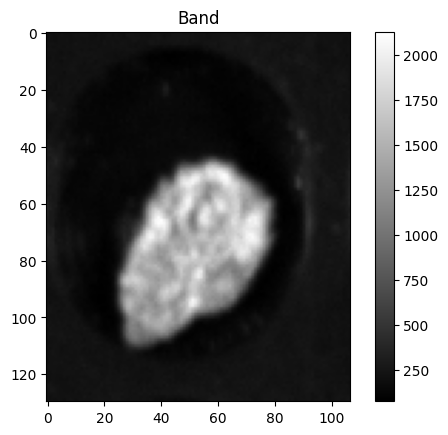

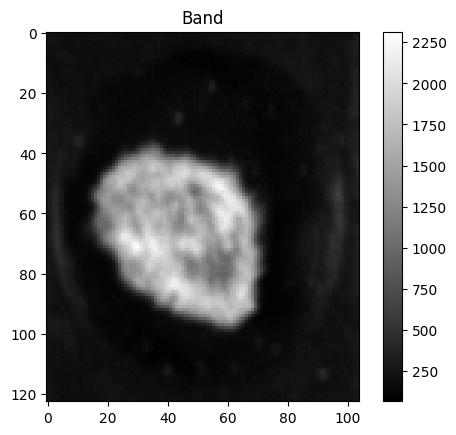

In [60]:
display_band(np.load(seed1_name))
display_band(np.load(seed2_name))